In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from urllib.request import urlopen
from bs4 import BeautifulSoup
from google.colab import data_table
from vega_datasets import data
import math

data_table.enable_dataframe_formatter()

In [ ]:
def webscrape (link):
  url = f"https://www.ndbc.noaa.gov/data/realtime2/{link}.txt"
  html = urlopen(url)

  soup = BeautifulSoup(html, 'lxml')
  type(soup)

  text = soup.get_text()

  text_list=text.split(' ')

  text_list = [value for value in text_list if value != '']
  text_list_copy = []
  for i in range(len(text_list)):
    if ('\n') in text_list[i]:
      temp = text_list[i].split('\n')
      for j in temp:
        text_list_copy.append(j)
    else:
      text_list_copy.append(text_list[i])

  index = []
  count =int(len(text_list_copy)/19)
  for i in range(count):
      index.append(i)

  column = []
  for i in range(19):
      column.append(text_list_copy[i]+' '+link)

  entries = []
  counter = 0
  for a in range(len(index)):
    temp = []
    for b in range(19):
      temp.append(text_list_copy[counter])
      counter+=1
    entries.append(temp)
  df = pd.DataFrame(
      entries,

      index,

      column,

  )
  return df

In [ ]:
def clean(link):
  name = webscrape(link)
  name[f"Time {link}"] = name[f"#YY {link}"]+" " +name[f"MM {link}"] + " " +name[f"DD {link}"] + " " +name[f"hh {link}"]
  name = name.drop(columns=[f"mm {link}", f"#YY {link}", f"MM {link}",f"DD {link}"])
  columns_titles = [f"Time {link}",f"hh {link}",f"WDIR {link}", f"WSPD {link}"]
  name=name.reindex(columns=columns_titles)
  name = name.iloc[1: , :]
  name = name.iloc[1: , :]
  return name

In [ ]:
def drop_repeat(link):
  
  name = clean(link)
  name_copy=name.copy(deep=True)
 
  current_hour = name.at[2 , f'hh {link}']

  for ind in range(3,len(name)):
    
    if current_hour == name.at[ind , f'hh {link}']:
      name_copy = name_copy.drop(ind)
    else:
      current_hour = name.at[ind , f'hh {link}']
  name_copy = name_copy.drop(columns=[f"hh {link}"])  

  return name_copy
  #return name

In [ ]:
fi=drop_repeat('KATP')
fi

,Time KATP,WDIR KATP,WSPD KATP
2,2022 01 29 18,330,7.2
3,2022 01 29 17,340,8.2
6,2022 01 29 14,350,9.8
7,2022 01 29 01,320,11.8
10,2022 01 29 00,320,10.3
...,...,...,...
3241,2021 12 15 02,100,7.2
3244,2021 12 15 01,120,6.7
3247,2021 12 15 00,110,7.2
3248,2021 12 15 00,110,7.2


In [ ]:
def before_jan(date):
  date = date.split()
  result = int(date[0])*365*24+int(date[1])*31*24+int(date[2])*24+int(date[3])
  chop_off = 17714159
  
  if result > chop_off:
    return True
  else:
    return False

In [ ]:
def after_dec(date):
  date = date.split()
  result = int(date[0])*365*24+int(date[1])*31*24+int(date[2])*24+int(date[3])
  chop_off = 17713272
  if result < chop_off:
    return True
  else:
    return False

In [ ]:
def compare(link):
  name = drop_repeat(link)
  for i, row in name.iterrows():
    if before_jan(name.at[i , f"Time {link}"]):
      name = name.drop(i)
    else:
      break
  for a, b in name[::-1].iterrows():
    if after_dec(name.at[i , f"Time {link}"]):
      name = name.drop(i)
    else:
      break
  return name



In [ ]:
def vector(link):
  name = compare(link)
  name = name.replace("MM", np.nan)
  name[f"North {link}"] = np.cos(np.pi / 180.0 * name[f'WDIR {link}'].astype(float)) * (name[f"WSPD {link}"].astype(float))
  name[f"East {link}"] = np.sin(np.pi / 180.0 * name[f'WDIR {link}'].astype(float)) * (name[f"WSPD {link}"].astype(float))
  name.drop(f'WDIR {link}',axis='columns', inplace=True)
  name.drop(f'WSPD {link}',axis='columns', inplace=True)
  #name.drop(f'hh {link}',axis='columns', inplace=True)
  name = name.interpolate()
  return name

In [ ]:
ejfi = vector('KBQX')
ejfi

,Time KBQX,North KBQX,East KBQX
13,2022 01 28 23,10.143520,1.788576
16,2022 01 28 22,3.550704,-2.050000
19,2022 01 28 21,3.852740,-1.402283
22,2022 01 28 20,4.366453,-3.663889
24,2022 01 28 19,6.598212,-1.163443
...,...,...,...
3241,2021 12 15 02,-2.314035,2.757760
3244,2021 12 15 01,-3.278217,3.906827
3247,2021 12 15 00,-3.663889,4.366453
3248,2021 12 15 00,-3.663889,4.366453


In [ ]:
import math
def make_goddict(list):
  master={}
  for input in list:
    master[input] = vector(input)
  return master

In [ ]:
result=make_goddict(['KIKT','KBQX','KMIS'])
result

{'KBQX':           Time KBQX  North KBQX  East KBQX
 13    2022 01 28 23   10.143520   1.788576
 16    2022 01 28 22    3.550704  -2.050000
 19    2022 01 28 21    3.852740  -1.402283
 22    2022 01 28 20    4.366453  -3.663889
 24    2022 01 28 19    6.598212  -1.163443
 ...             ...         ...        ...
 3241  2021 12 15 02   -2.314035   2.757760
 3244  2021 12 15 01   -3.278217   3.906827
 3247  2021 12 15 00   -3.663889   4.366453
 3248  2021 12 15 00   -3.663889   4.366453
 3249  2021 12 15 00   -3.663889   4.366453
 
 [1082 rows x 3 columns], 'KIKT':           Time KIKT  North KIKT  East KIKT
 2     2021 12 21 20    1.800000  -3.117691
 3     2021 12 21 19    1.800000  -3.117691
 6     2021 12 21 18    2.057018  -2.937726
 9     2021 12 21 17    2.314035  -2.757760
 12    2021 12 21 16    2.635429  -3.140782
 ...             ...         ...        ...
 1317  2021 12 03 01   -1.991716  -1.671248
 1320  2021 12 03 00   -1.991716  -1.671248
 1323  2021 12 02 23   -1.991716 

This is now the glorious code to do ARIMA stuff!

In [ ]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'


In [ ]:
def daysumofmonthsbefore(month):
  if month == 1:
    return 0
  elif month == 2:
    return 31
  elif month == 3:
    return 59
  elif month == 4:
    return 90
  elif month == 5:
    return 120
  elif month == 6:
    return 151
  elif month == 7:
    return 181
  elif month == 8:
    return 212
  elif month == 9:
    return 243
  elif month == 10:
    return 273
  elif month == 11:
    return 304
  else:
    return 334
def jesus_hours(date):
  date = date.split()
  return (int(date[0])-2021)*365*24+daysumofmonthsbefore(int(date[1]))*24+int(date[2])*24+int(date[3])

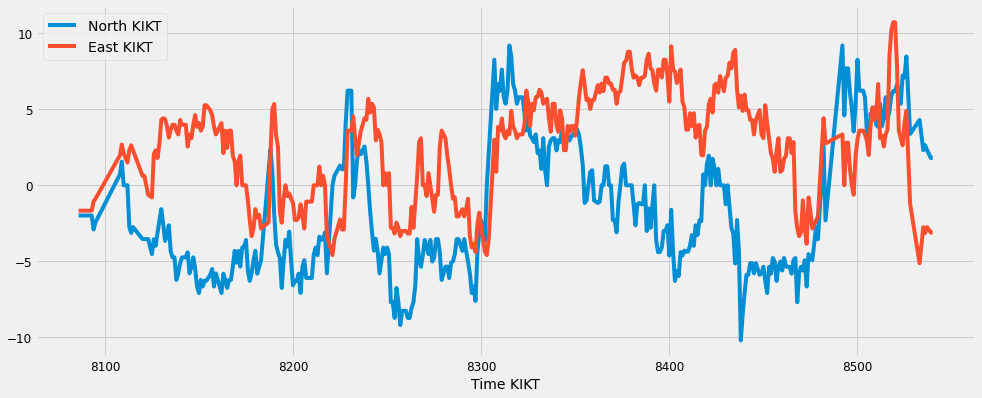

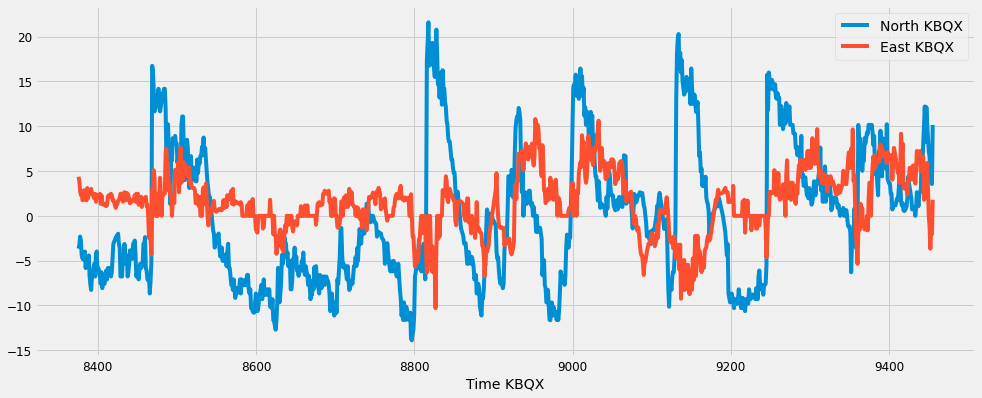

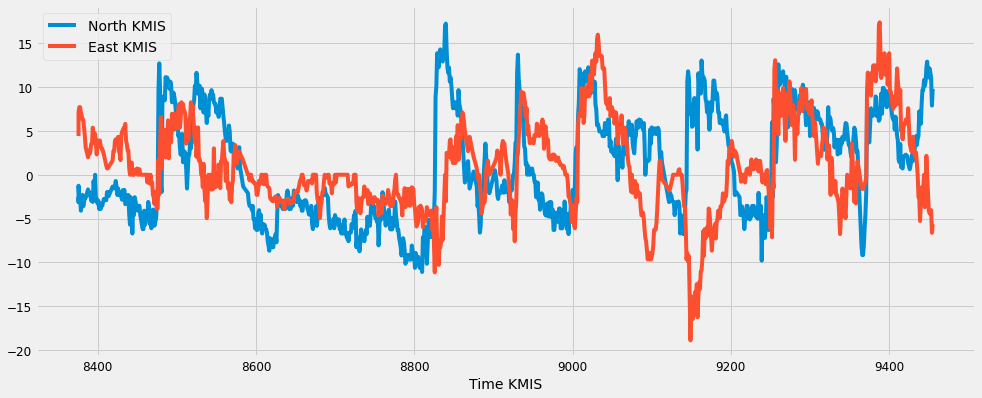

In [ ]:
result=make_goddict(['KIKT','KBQX','KMIS'])
for link in result.keys():
  result[link][f"Time {link}"] = result[link][f"Time {link}"].apply(jesus_hours)
  result[link] = result[link].set_index(f"Time {link}")
  result[link].plot(figsize=(15,6))

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
test = result['KMIS']
#print(test)
inputs = []
north_outputs = []
east_outputs = []
print(test)
testdict = test.to_dict()
print(testdict['North KMIS'])
for idx in range(9383, 8500, -1):
  input = []
  for i in range(1,5):
    input.append(testdict['North KMIS'][idx-25*i])
    input.append(testdict['East KMIS'][idx-25*i])
  inputs.append(input)
  north_outputs.append(testdict['North KMIS'][idx])
  east_outputs.append(testdict['East KMIS'][idx])
inputs, north_outputs, east_outputs = np.array(inputs), np.array(north_outputs), np.array(east_outputs)




           North KMIS  East KMIS
Time KMIS                       
9455         9.786087  -5.650000
9454         7.890258  -6.620712
9453        11.088373  -4.035838
9452        11.652188  -4.241050
9451        12.122035  -4.412060
...               ...        ...
8378        -2.804565   7.705479
8377        -2.804565   7.705479
8376        -1.250267   7.090616
8376        -3.100000   5.369358
8376        -2.550000   4.416730

[1082 rows x 2 columns]
{9455: 9.786087062764155, 9454: 7.890257764125471, 9453: 11.08837292527372, 9452: 11.652188497745264, 9451: 12.122034808138219, 9450: 11.08837292527372, 9449: 11.620731485544056, 9448: 12.9, 9447: 12.21161613735138, 9446: 10.635923732531847, 9445: 10.148680304487812, 9444: 10.8, 9443: 9.65111597951964, 9442: 9.65111597951964, 9441: 8.075423574700105, 9440: 5.8023702053557376, 9439: 6.281564433575618, 9438: 7.2356331800514955, 9437: 4.416729559300635, 9436: 4.1, 9435: 3.3828934348292705, 9434: 4.416729559300637, 9433: 3.5507041555161982, 943

In [ ]:
north_model = LinearRegression().fit(inputs, north_outputs)
east_model = LinearRegression().fit(inputs, east_outputs)
north_r_sq = north_model.score(inputs, north_outputs)
east_r_sq = east_model.score(inputs, east_outputs)
print('r^2 = ' + str(north_r_sq))
print('intercept ' + str(north_model.intercept_))
print('slope', north_model.coef_)

r^2 = 0.21396573283172282
intercept 0.46522339954538633
slope [ 0.36293074  0.0511899  -0.17121774  0.28360524  0.05904746  0.0066021
  0.10688699 -0.21806552]


In [ ]:
rand_input = np.array([[12, 12, 24, 16, 15, 35, 24, 23]])
north_pred = north_model.predict(rand_input)
east_pred = east_model.predict(rand_input)
print(north_pred, east_pred)

[4.52969513] [5.58135246]


In [ ]:
north_predictions = testdict['North KMIS'].copy()
east_predictions = testdict['East KMIS'].copy()

print(north_predictions)

north_predictions_max = max(north_predictions.keys())
east_predictions_max = max(east_predictions.keys())

rows = 9455
for i in range(72):
  past_values = []
  for j in range(1,5):
    past_values.append(north_predictions[rows-25*j+i-1])
    past_values.append(east_predictions[rows-25*j+i-1])
  north_predictions[north_predictions_max + i + 1] = north_model.predict([past_values])[0]
  east_predictions[east_predictions_max + i + 1] = east_model.predict([past_values])[0]
print(testdict['North KMIS'])
print(north_predictions)

{9455: 9.786087062764155, 9454: 7.890257764125471, 9453: 11.08837292527372, 9452: 11.652188497745264, 9451: 12.122034808138219, 9450: 11.08837292527372, 9449: 11.620731485544056, 9448: 12.9, 9447: 12.21161613735138, 9446: 10.635923732531847, 9445: 10.148680304487812, 9444: 10.8, 9443: 9.65111597951964, 9442: 9.65111597951964, 9441: 8.075423574700105, 9440: 5.8023702053557376, 9439: 6.281564433575618, 9438: 7.2356331800514955, 9437: 4.416729559300635, 9436: 4.1, 9435: 3.3828934348292705, 9434: 4.416729559300637, 9433: 3.5507041555161982, 9432: 2.7577599952283207, 9431: 1.8000000000000005, 9430: 1.5732926592980765, 9429: 2.3000000000000003, 9428: 1.5500000000000005, 9427: 1.087566719800475, 9426: 0.6251334396009495, 9425: 0.9897946127015034, 9424: 1.3370909680353642, 9423: 2.120524888619147, 9422: 2.120524888619147, 9421: 2.291534960281981, 9420: 2.120524888619147, 9419: 2.120524888619147, 9418: 1.9495148169563123, 9417: 0.7119575284344146, 9416: 0.885605706101345, 9415: 0.88560570610134

           North KMIS  East KMIS
Time KMIS                       
9455         9.786087  -5.650000
9454         7.890258  -6.620712
9453        11.088373  -4.035838
9452        11.652188  -4.241050
9451        12.122035  -4.412060
...               ...        ...
8378        -2.804565   7.705479
8377        -2.804565   7.705479
8376        -1.250267   7.090616
8376        -3.100000   5.369358
8376        -2.550000   4.416730

[1082 rows x 2 columns]


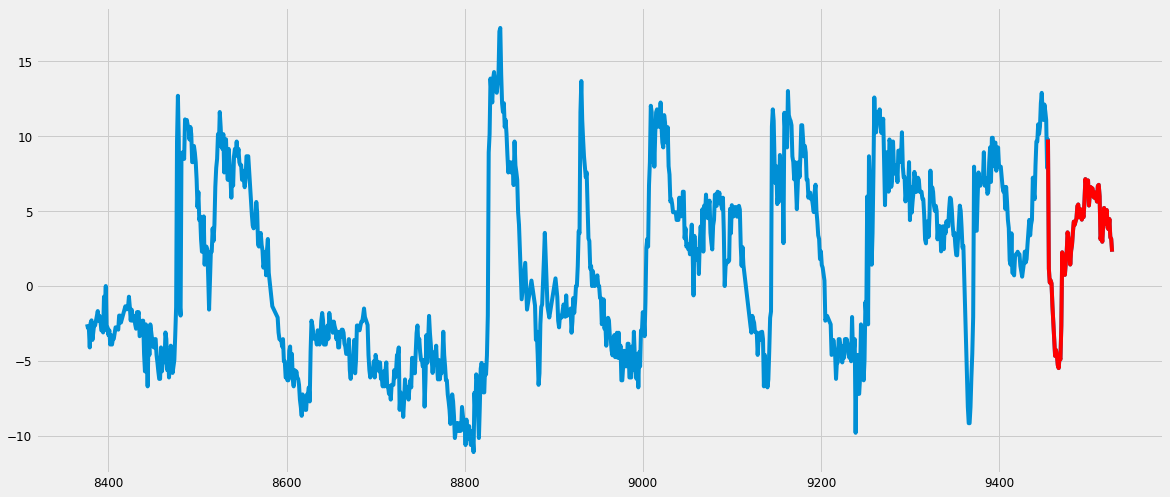

In [ ]:
import matplotlib.pylab as plt

my_dict = north_predictions
myList = my_dict.items()
myList = sorted(myList) 
x, y = zip(*myList) 

plt.plot(x, y)
x2 = x[9455-8376:]
y2 = y[9455-8376:]
plt.plot(x2, y2, color="red")
print(result['KMIS'])
#plt.plot(result['KMIS'].index, result['KMIS']['North KMIS'], color="green")
plt.show()

ARIMA didn't work :((


Int64Index([9455, 9454, 9453, 9452, 9451, 9450, 9449, 9448, 9447, 9446,
            ...
            8665, 8664, 8663, 8662, 8661, 8660, 8659, 8658, 8657, 8656],
           dtype='int64', name='Time KMIS', length=800)


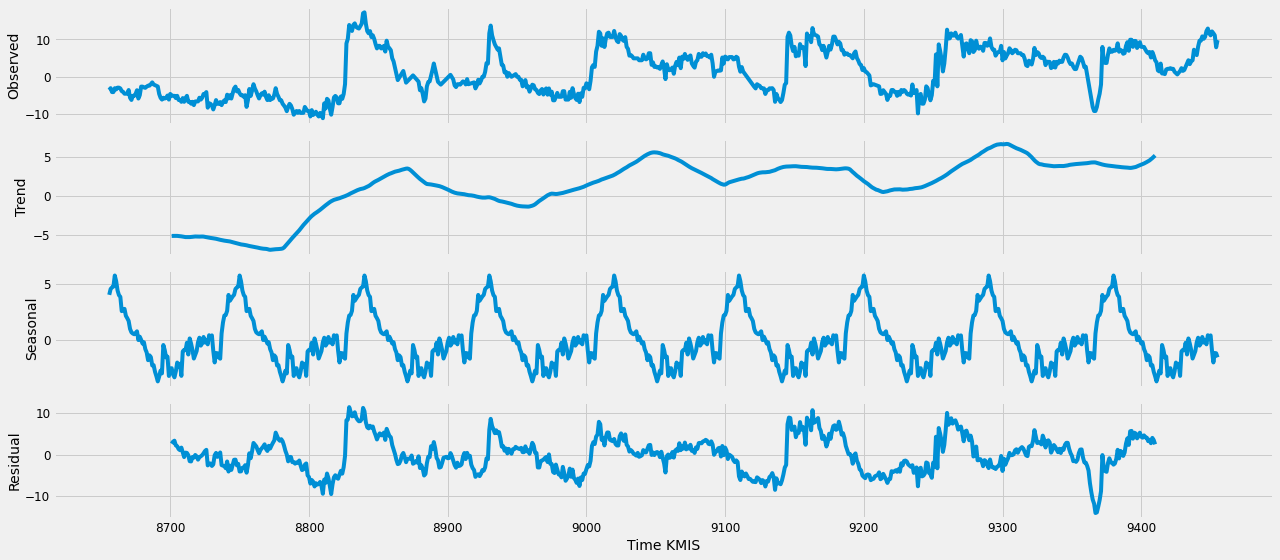

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 18,8
testseries = result['KMIS']['North KMIS']
testseries = testseries[0:800]
print(testseries.index)
decomposition = sm.tsa.seasonal_decompose(testseries, model='additive', freq=90)
fig = decomposition.plot()
plt.show()

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
min_aic = (float('inf'), '')

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(testseries, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            if min_aic[0] > results.aic:
              min_aic = (results.aic, 'ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

print(min_aic)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:5205.502590398569
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:4756.05862615401
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:4859.194375524222


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:4780.5498047941655
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:4693.474021415508


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:4663.194329654687
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:4788.05572459881


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:4662.275190600303
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:4418.650944458635


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:4091.0858467683415
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:4245.516174932052


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:4152.951113898704
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:4050.772439269954


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:4035.280380886549


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:4177.542001029453


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:4019.075883684396
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:3080.2892133718474
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:3039.5849944106026


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:3623.4257224951366


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:3032.7910298418806
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:3042.306909959572


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:3041.282398332981
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:3351.5169220411


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:3041.904439920013
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:3059.7881200443744


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:3020.8768698173362
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:3609.0320903322745


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:3015.644199008574
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:3027.4055391959964


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:3022.8411132281526


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:3344.471545253101


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:3023.304987029869
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:3071.216936917292


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:3029.734219009145
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:3587.4034489616765


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:3023.0685216656266
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:3029.5411929100774


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:3031.0636708104707


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:3327.379966038229


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:3033.0199161753444
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:3056.9960373907734


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:3015.677391704898
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:3582.8758500345684


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:3009.610108206561
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:3018.2916914153684


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:3017.1679477347643


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:3324.779136759658


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:3018.8317692522596
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:3064.3033076243087
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:3022.732599426456


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:3616.715191830954


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:3017.1017591885566
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:3022.6417556264473


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:3024.627203127812


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:3340.428409967558


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:3025.6149803407147
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:3059.16457110608


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:3019.1698156586726
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:3610.7449053788346


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:3013.685824471278
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:3022.8565728673075


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:3021.161660089625


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:3341.351912758231


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:3021.1413220633485
(3009.610108206561, 'ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:3009.610108206561')


In [ ]:
mod = sm.tsa.statespace.SARIMAX(testseries,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9748      0.010    101.707      0.000       0.956       0.994
ma.L1         -0.1229      0.023     -5.450      0.000      -0.167      -0.079
ma.S.L12      -1.0000    109.681     -0.009      0.993    -215.971     213.971
sigma2         2.6800    293.983      0.009      0.993    -573.516     578.876


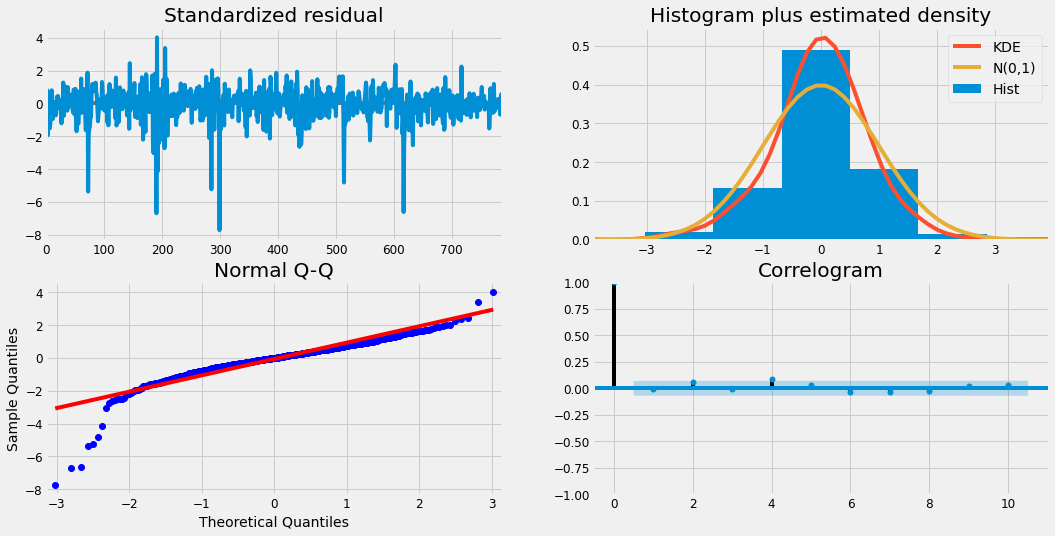

In [ ]:
results.plot_diagnostics(figsize=(16,8))
plt.show()

9000    0.893395
9001    1.052004
9002    0.943957
9003    0.593818
9004    0.612466
          ...   
9496    0.612466
9497    0.599835
9498    0.541539
9499    0.607395
9500    0.918700
Length: 501, dtype: float64


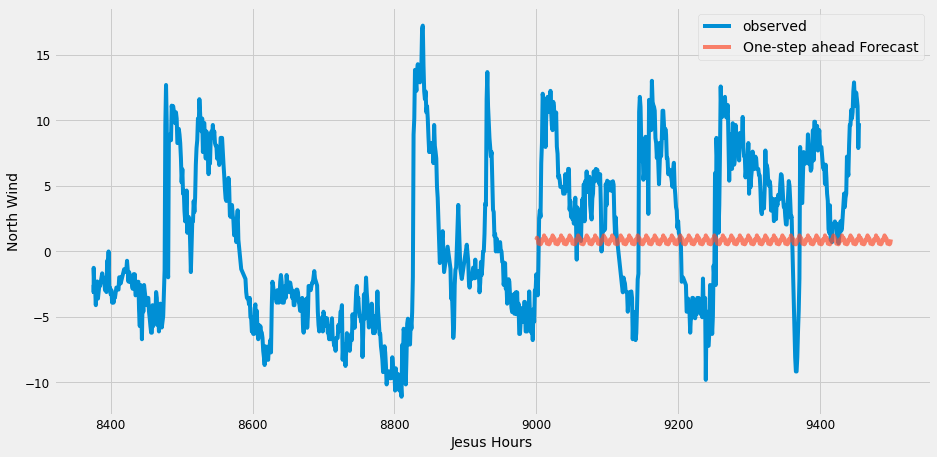

In [ ]:
pred = results.get_prediction(start=9000, end=9500, dynamic=False)
print(pred)
pred_ci = pred.conf_int()
ax = result['KMIS']['North KMIS'].plot(label='observed')
print(pred.predicted_mean)
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
#ax.fill_between(pred_ci.index,
                #pred_ci.iloc[:, 0],
                #pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Jesus Hours')
ax.set_ylabel('North Wind')
plt.legend()
plt.show()

SPACER





